# 5 - Quantum error correction inspired by classical codes

## Core Task 5.1 - Explore QEC codes inspired by classical codes

[TODO, 70pts]:

Classical error correcting codes provide a natural and powerful pathway to constructing quantum codes by directly translating classical parity checks into quantum stabilizer measurements. In particular, any linear classical code can be mapped to a quantum code that detects and corrects **bit flip (X) errors** by promoting each classical parity check into a multi-qubit ( Z )-type stabilizer. In this construction, classical codewords become logical quantum states, and the syndrome extraction process is identical in spirit to classical decoding. This approach is especially well suited for hardware with **strong noise bias**, where one error channel dominates. In our case, biased cat qubits exponentially suppress phase flip errors, leaving bit flips as the primary failure mode. As a result, we can focus entirely on X-error correction, allowing us to use a much wider and more efficient family of classical codes than would be possible for fully general quantum noise.

The final and core challenge is to choose any classical error correcting code (or family of codes), translate it into its quantum counterpart, and benchmark it against the repetition code that you already implemented. You will simulate the resulting quantum code in **Stim**, extract syndromes, perform decoding, and compare key performance metrics such as logical error rate versus number of physical qubits at a fixed physical error rate, encoding efficiency ( k/n ), the effective distance of the code and required hardware connectivity (i.e. what two-qubit gates are needed). This exploration will show how classical coding theory can be directly leveraged to design quantum codes that outperform simple repetition strategies when the noise is strongly biased.

*Optionally*, only if time permits, you may wish to demonstrate a universal, fault-tolerant set of logical gates for your code, starting with the Clifford group and extending to non-Clifford gates.


Please refer to `./2-classical-to-quantum-codes.ipynb` for a step-by-step introduction to translating a classical code into a quantum bit-flip–correcting code, along with a curated (but not exhaustive) list of classical code families to use as inspiration. You should consider this notebook required reading for the core task in this challenge.

This is an open-ended challenge, judged by the criteria in `README.md` (Technical Soundness, Depth, Originality, Impact, Clarity). Solution links §§1–4, states H1–H3 and scaling [4]; simulations only where they validate these.

#### 5.1 Bit-flip correction with LDPC

- **Goal:** Implement an **LDPC-based** bit-flip code and document its parameters; compare with repetition on code metrics (repetition has simulated LER; LDPC does not, due to decoder limitation).
- **Reference:** [arXiv:2401.09541](https://arxiv.org/pdf/2401.09541) (last reference in the paper points to GitHub and code https://github.com/ElieGouzien/elliptic_log_cat).
- **Scope:** Bit flips only; compare encoding rate (k/n), distance (d_X), and resources; LER comparison is repetition-only (see limitations).


In [117]:
# --- Inner bit-flip LDPC from Alice & Bob ideas (arXiv:2401.09541) ---
# 2D local, weight-4 parity checks; BP decoding; LER vs physical p.
import numpy as np
import matplotlib.pyplot as plt
import stim
from ldpc import BpDecoder

def build_2d_local_H(L, H):
    """
    2D local bit-flip LDPC: one weight-4 parity check per 2x2 face on L×H grid.
    Qubit index: column-major (row, col) -> row + col*H. Same idea as A&B: local, low-weight.
    """
    n = L * H
    m = (L - 1) * (H - 1)
    P = np.zeros((m, n), dtype=np.uint8)
    idx = 0
    for col in range(L - 1):
        for row in range(H - 1):
            # 2x2 face: (row,col), (row+1,col), (row,col+1), (row+1,col+1)
            i00 = row + col * H
            i10 = (row + 1) + col * H
            i01 = row + (col + 1) * H
            i11 = (row + 1) + (col + 1) * H
            P[idx, [i00, i10, i01, i11]] = 1
            idx += 1
    return P

def rank_gf2(M):
    A = np.asarray(M, dtype=np.uint8).copy()
    m, n = A.shape
    r = 0
    for j in range(n):
        pivot = -1
        for i in range(r, m):
            if A[i, j]:
                pivot = i
                break
        if pivot == -1:
            continue
        if pivot != r:
            A[[r, pivot]] = A[[pivot, r]]
        for i in range(m):
            if i != r and A[i, j]:
                A[i] = (A[i] + A[r]) % 2
        r += 1
    return r

def code_dimension(H):
    return H.shape[1] - rank_gf2(H)

def solve_Hx_eq_s(H, s):
    H = np.asarray(H, dtype=np.uint8)
    s = np.asarray(s, dtype=np.uint8).ravel()
    m, n = H.shape
    A = np.hstack([H.copy(), s.reshape(-1, 1)])
    r, pivot_cols = 0, []
    for j in range(n):
        pivot = -1
        for i in range(r, m):
            if A[i, j]:
                pivot = i
                break
        if pivot == -1:
            continue
        if pivot != r:
            A[[r, pivot]] = A[[pivot, r]]
        for i in range(m):
            if i != r and A[i, j]:
                A[i] = (A[i] + A[r]) % 2
        pivot_cols.append((r, j))
        r += 1
    x = np.zeros(n, dtype=np.uint8)
    for (i, j) in reversed(pivot_cols):
        x[j] = A[i, n]
        for k in range(j + 1, n):
            if A[i, k]:
                x[j] = (x[j] + x[k]) % 2
    return x

def ldpc_bitflip_circuit(H, p):
    n, m = H.shape[1], H.shape[0]
    c = stim.Circuit()
    data = list(range(n))
    anc = list(range(n, n + m))
    c.append("R", data + anc)
    c.append("X_ERROR", data, p)
    for i, a in enumerate(anc):
        for j in np.flatnonzero(H[i]):
            c.append("CNOT", [j, a])
        c.append("M", a)
        c.append("DETECTOR", [stim.target_rec(-1)])
    c.append("M", data)
    for j in range(n):
        c.append("OBSERVABLE_INCLUDE", [stim.target_rec(-(n - j))], j)
    return c

def decode_bp_fallback(H, p, syndrome, received, max_iter=100):
    n = H.shape[1]
    bp = BpDecoder(H, error_rate=float(p), max_iter=max_iter, bp_method="product_sum")
    e_hat = np.asarray(bp.decode(syndrome)).ravel()[:n]
    if not np.array_equal((H @ e_hat) % 2, syndrome):
        e_hat = solve_Hx_eq_s(H, syndrome)
    return (received + e_hat) % 2

def simulate_ler(H, p, shots=2000):
    c = ldpc_bitflip_circuit(H, p)
    sampler = c.compile_detector_sampler()
    samples = np.asarray(sampler.sample(shots=shots, append_observables=True), dtype=np.uint8)
    if samples.ndim == 1:
        samples = samples.reshape(shots, -1)
    num_dets, num_obs = c.num_detectors, c.num_observables
    m = H.shape[0]
    syndrome = samples[:, :num_dets][:, :m]
    received = samples[:, num_dets : num_dets + num_obs][:, : H.shape[1]]
    failures = 0
    for i in range(shots):
        res = decode_bp_fallback(H, p, syndrome[i], received[i])
        if np.any(res):
            failures += 1
    return failures / shots


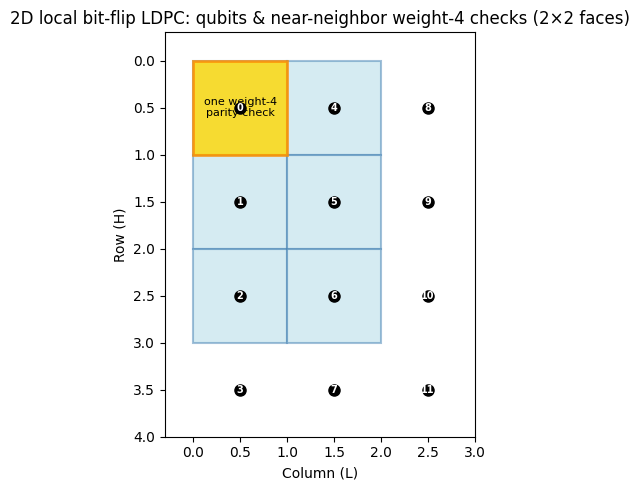

In [118]:

# ---------- 2D visualization: near neighbors (one weight-4 parity check per 2x2 face) ----------
# Qubit index: (row, col) -> row + col*H. Grid: H rows, L columns.
def plot_2d_ldpc_grid(L, H, ax=None, highlight_one_face=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    # Draw each 2x2 face (one weight-4 parity check): rectangle from (col, row) to (col+1, row+1)
    for col in range(L - 1):
        for row in range(H - 1):
            face = plt.Rectangle((col, row), 1, 1, fill=True, facecolor="lightblue", edgecolor="steelblue", linewidth=1.5, alpha=0.5)
            ax.add_patch(face)
    # Optionally highlight one face (top-left) to show "one weight-4 parity check"
    if highlight_one_face and L >= 2 and H >= 2:
        ax.add_patch(plt.Rectangle((0, 0), 1, 1, fill=True, facecolor="gold", edgecolor="darkorange", linewidth=2, alpha=0.8))
        ax.text(0.5, 0.5, "one weight-4\nparity check", ha="center", va="center", fontsize=8, color="black")
    # Qubits at (col + 0.5, row + 0.5); index = row + col*H
    for col in range(L):
        for row in range(H):
            q = row + col * H
            ax.plot(col + 0.5, row + 0.5, "ko", markersize=8)
            ax.text(col + 0.5, row + 0.5, str(q), ha="center", va="center", fontsize=7, color="white", weight="bold")
    ax.set_xlim(-0.3, L)
    ax.set_ylim(-0.3, H)
    ax.set_aspect("equal")
    ax.set_xlabel("Column (L)")
    ax.set_ylabel("Row (H)")
    ax.set_title("2D local bit-flip LDPC: qubits & near-neighbor weight-4 checks (2×2 faces)")
    ax.invert_yaxis()
    return ax

# Small example: L=3, H=4 (n=12 qubits, 6 parity checks)
L0, H0 = 3, 4
plot_2d_ldpc_grid(L0, H0)
plt.tight_layout()
plt.show()


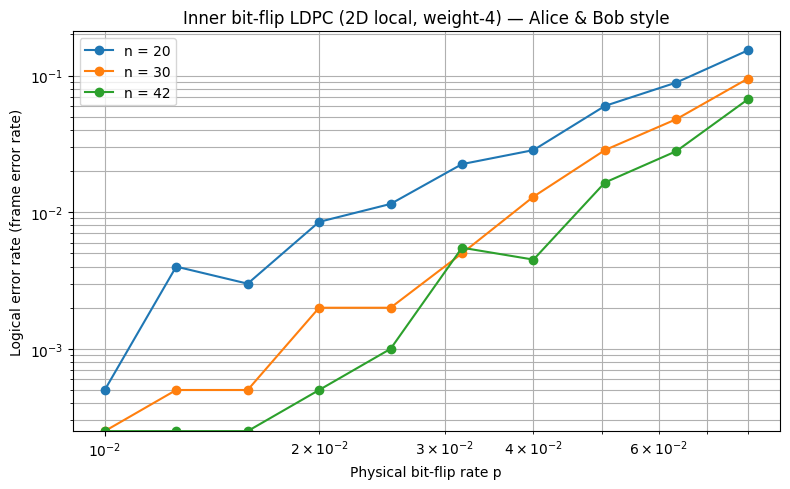

In [119]:

# ---------- Code sizes from 2D local family (vary L, H) ----------
# Same idea as A&B: 2D local codes with different n; plot LER vs p.
sizes = [(4, 5), (5, 6), (6, 7)]   # (L,H) -> n = 20, 30, 42
error_rates = np.logspace(np.log10(0.01), np.log10(0.08), 10)
shots = 2000

results = {}
for (L, H) in sizes:
    H_mat = build_2d_local_H(L, H)
    n = L * H
    k = code_dimension(H_mat)
    results[n] = []
    for p in error_rates:
        ler = simulate_ler(H_mat, p, shots=shots)
        results[n].append(max(ler, 0.5 / shots))

plt.figure(figsize=(8, 5))
for n in results:
    plt.loglog(error_rates, results[n], "o-", label=f"n = {n}")
plt.xlabel("Physical bit-flip rate p")
plt.ylabel("Logical error rate (frame error rate)")
plt.title("Inner bit-flip LDPC (2D local, weight-4) — Alice & Bob style")
plt.grid(True, which="both")
plt.legend()
plt.ylim(bottom=0.5 / shots)
plt.tight_layout()
plt.show()

In [120]:
# LDPC inner bit-flip correction circuit (Alice & Bob style).
# Based on: arXiv:2401.09541 (LDPC-cat codes, 2D local, weight-4, BP decoding).
# References: arXiv:2401.09541, 2601.10786, 2302.06639, 1907.11729

import numpy as np
import matplotlib.pyplot as plt
import stim
from ldpc import BpDecoder
from IPython.display import display

# ---------------------------------------------------------------------------
# 1) Parity-check matrix: 2D local, weight-4 (one check per 2x2 face)
# ---------------------------------------------------------------------------

def build_2d_local_H(L, H_grid):
    """
    2D local bit-flip LDPC: one weight-4 parity check per 2x2 face on L×H grid.
    Qubit index column-major: (row, col) -> row + col*H_grid.
    """
    n = L * H_grid
    m = (L - 1) * (H_grid - 1)
    P = np.zeros((m, n), dtype=np.uint8)
    idx = 0
    for col in range(L - 1):
        for row in range(H_grid - 1):
            i00 = row + col * H_grid
            i10 = (row + 1) + col * H_grid
            i01 = row + (col + 1) * H_grid
            i11 = (row + 1) + (col + 1) * H_grid
            P[idx, [i00, i10, i01, i11]] = 1
            idx += 1
    return P


def rank_gf2(M):
    A = np.asarray(M, dtype=np.uint8).copy()
    m, n = A.shape
    r = 0
    for j in range(n):
        pivot = -1
        for i in range(r, m):
            if A[i, j]:
                pivot = i
                break
        if pivot == -1:
            continue
        if pivot != r:
            A[[r, pivot]] = A[[pivot, r]]
        for i in range(m):
            if i != r and A[i, j]:
                A[i] = (A[i] + A[r]) % 2
        r += 1
    return r


def code_dimension(H):
    """Number of logical bits k = n - rank(H) over GF(2).
    For the 2D local LDPC (one weight-4 check per 2x2 face), rank(H) = (L-1)(H-1),
    so k = L*H - (L-1)(H-1) = L + H - 1."""
    return H.shape[1] - rank_gf2(H)


def solve_Hx_eq_s(H, s):
    H = np.asarray(H, dtype=np.uint8)
    s = np.asarray(s, dtype=np.uint8).ravel()
    m, n = H.shape
    A = np.hstack([H.copy(), s.reshape(-1, 1)])
    r, pivot_cols = 0, []
    for j in range(n):
        pivot = -1
        for i in range(r, m):
            if A[i, j]:
                pivot = i
                break
        if pivot == -1:
            continue
        if pivot != r:
            A[[r, pivot]] = A[[pivot, r]]
        for i in range(m):
            if i != r and A[i, j]:
                A[i] = (A[i] + A[r]) % 2
        pivot_cols.append((r, j))
        r += 1
    x = np.zeros(n, dtype=np.uint8)
    for (i, j) in reversed(pivot_cols):
        x[j] = A[i, n]
        for k in range(j + 1, n):
            if A[i, k]:
                x[j] = (x[j] + x[k]) % 2
    return x


# ---------------------------------------------------------------------------
# 2) Circuit: Stim LDPC bit-flip (one round)
# ---------------------------------------------------------------------------

def ldpc_bitflip_circuit(H, p):
    """
    One round: R, X_ERROR(p) on data, syndrome (CNOT + M + DETECTOR), M on data, OBSERVABLE_INCLUDE.
    H: (m x n) parity-check matrix; p: physical bit-flip rate.
    """
    n, m = H.shape[1], H.shape[0]
    c = stim.Circuit()
    data = list(range(n))
    anc = list(range(n, n + m))
    c.append("R", data + anc)
    c.append("X_ERROR", data, p)
    for i, a in enumerate(anc):
        for j in np.flatnonzero(H[i]):
            c.append("CNOT", [j, a])
        c.append("M", a)
        c.append("DETECTOR", [stim.target_rec(-1)])
    c.append("M", data)
    for j in range(n):
        c.append("OBSERVABLE_INCLUDE", [stim.target_rec(-(n - j))], j)
    return c


# ---------------------------------------------------------------------------
# 3) Decoding: BP + syndrome-consistency fallback
# ---------------------------------------------------------------------------

def decode_bp_fallback(H, p, syndrome, received, max_iter=100):
    n = H.shape[1]
    bp = BpDecoder(H, error_rate=float(p), max_iter=max_iter, bp_method="product_sum")
    e_hat = np.asarray(bp.decode(syndrome)).ravel()[:n]
    if not np.array_equal((H @ e_hat) % 2, syndrome):
        e_hat = solve_Hx_eq_s(H, syndrome)
    return (received + e_hat) % 2


def simulate_ler(H, p, shots=2000):
    c = ldpc_bitflip_circuit(H, p)
    sampler = c.compile_detector_sampler()
    samples = np.asarray(sampler.sample(shots=shots, append_observables=True), dtype=np.uint8)
    if samples.ndim == 1:
        samples = samples.reshape(shots, -1)
    num_dets, num_obs = c.num_detectors, c.num_observables
    m = H.shape[0]
    syndrome = samples[:, :num_dets][:, :m]
    received = samples[:, num_dets : num_dets + num_obs][:, : H.shape[1]]
    failures = 0
    for i in range(shots):
        res = decode_bp_fallback(H, p, syndrome[i], received[i])
        if np.any(res):
            failures += 1
    return failures / shots



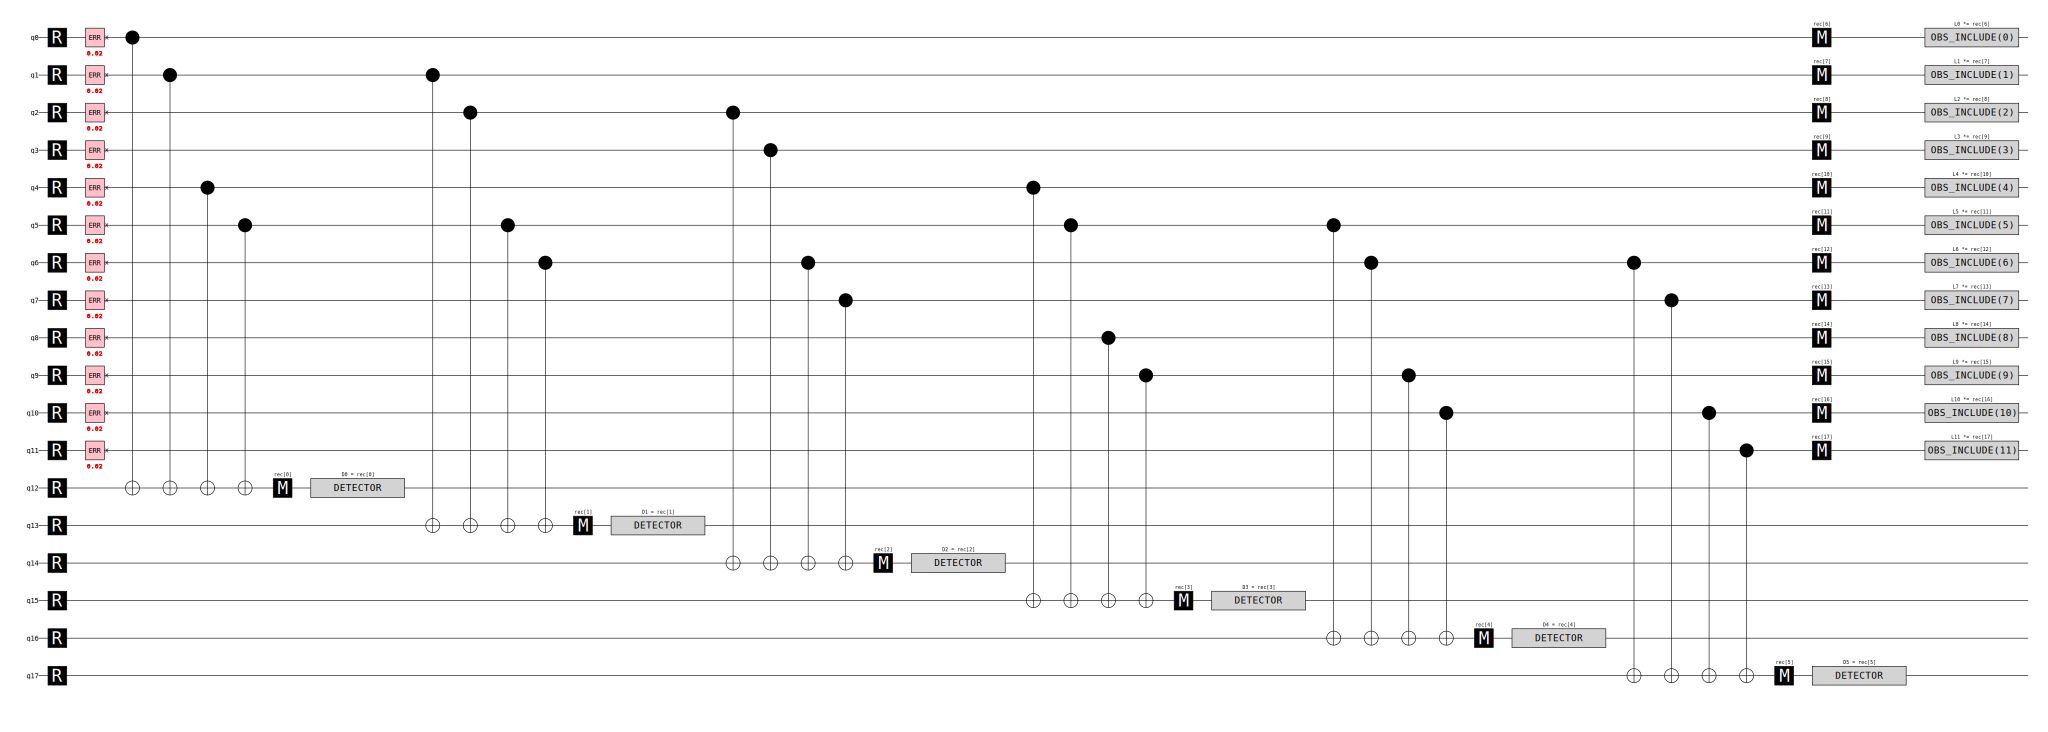

In [121]:
# ---------------------------------------------------------------------------
# 4) Main: build circuit, optionally print it, run simulation, plot
# ---------------------------------------------------------------------------

# Build one circuit and visualize (same style as Bell-state example)
L0, H0 = 3, 4
p_phys = 0.02
H_mat = build_2d_local_H(L0, H0)
circuit = ldpc_bitflip_circuit(H_mat, p_phys)
#print(circuit)
#print("")
#print(circuit.diagram())
#print("")
# Render timeline as SVG (qubit lines, gates, DETECTOR — like Bell-state example)
display(circuit.diagram("timeline-svg"))

n=20, k=8 done
n=30, k=10 done
n=42, k=12 done


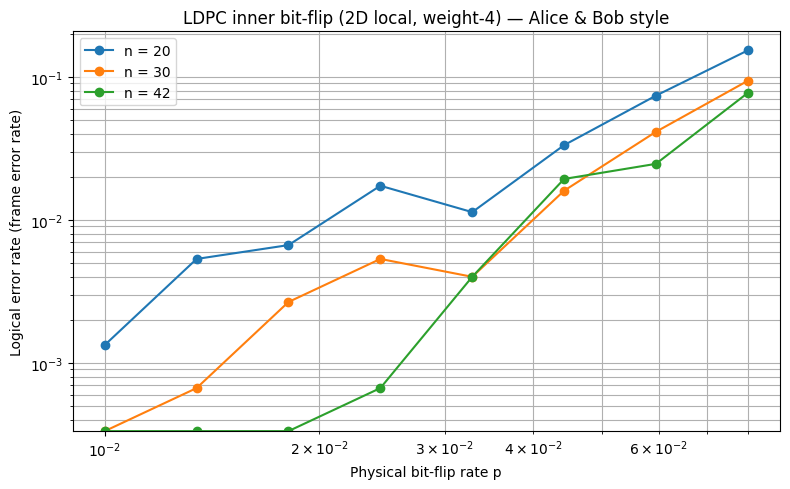

In [122]:
# Simulate LER vs p for several code sizes
sizes = [(4, 5), (5, 6), (6, 7)]   # (L,H) -> n = 20, 30, 42
p_phys = 0.02
shots = 1500
error_rates = np.logspace(np.log10(0.01), np.log10(0.08), 8)
results = {}
for (L, H) in sizes:
    H_mat = build_2d_local_H(L, H)
    n = L * H
    k = code_dimension(H_mat)
    results[n] = []
    for p in error_rates:
        ler = simulate_ler(H_mat, p, shots=shots)
        results[n].append(max(ler, 0.5 / shots))
    print(f"n={n}, k={k} done")

plt.figure(figsize=(8, 5))
for n in results:
    plt.loglog(error_rates, results[n], "o-", label=f"n = {n}")
plt.xlabel("Physical bit-flip rate p")
plt.ylabel("Logical error rate (frame error rate)")
plt.title("LDPC inner bit-flip (2D local, weight-4) — Alice & Bob style")
plt.grid(True, which="both")
plt.legend()
plt.ylim(bottom=0.5 / shots)
plt.tight_layout()
plt.show()

Extrapolated n/k for LER = 1e-10: n/k ≈ 13.1


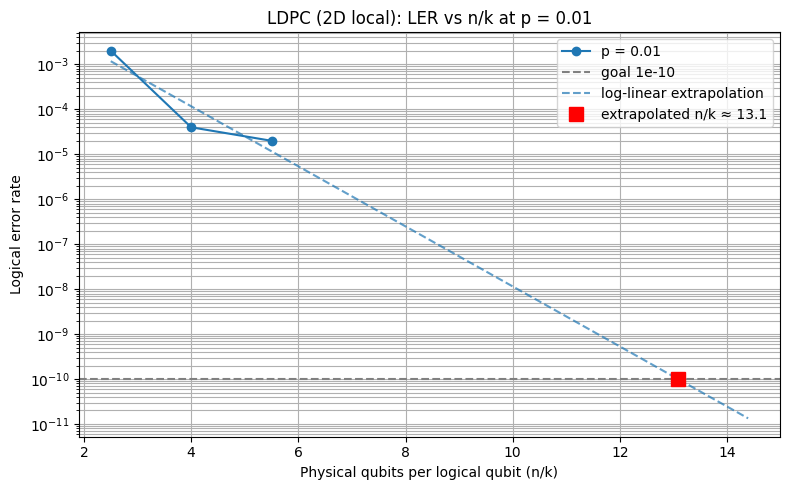

In [132]:
# Physical qubits per logical qubit: plot LER vs n/k at p = 0.01 + extrapolate n/k for LER = 1e-10
import numpy as np

bit_flip_prob = 0.01
goal_logical_error_rate = 1e-10
sizes_goal = [(4, 5), (7, 8), (10, 11)]  # add more (L,H) as needed
shots_goal = 50_000

n_over_k_vals = []
ler_vals = []
for (L, H) in sizes_goal:
    H_mat = build_2d_local_H(L, H)
    n = L * H
    k = code_dimension(H_mat)  # k = L + H - 1
    ler = simulate_ler(H_mat, bit_flip_prob, shots=shots_goal)
    n_over_k_vals.append(n / k)
    ler_vals.append(max(ler, 0.5 / shots_goal))  # avoid log(0) if 0 errors

# Extrapolate n/k for LER = 1e-10 (log-linear: log10(LER) vs n/k)
x = np.array(n_over_k_vals)
y = np.log10(np.array(ler_vals))
slope, intercept = np.polyfit(x, y, 1)
target_log_ler = np.log10(goal_logical_error_rate)
n_over_k_at_goal = (target_log_ler - intercept) / slope
print(f"Extrapolated n/k for LER = {goal_logical_error_rate:.0e}: n/k ≈ {n_over_k_at_goal:.1f}")

# Plot
plt.figure(figsize=(8, 5))
plt.semilogy(n_over_k_vals, ler_vals, "o-", label=f"p = {bit_flip_prob}")
plt.axhline(goal_logical_error_rate, color="gray", linestyle="--", label=f"goal {goal_logical_error_rate:.0e}")
x_fit = np.linspace(min(x), max(n_over_k_at_goal, x.max()) * 1.1, 100)
plt.plot(x_fit, 10**(slope * x_fit + intercept), "--", color="C0", alpha=0.7, label="log-linear extrapolation")
plt.plot(n_over_k_at_goal, goal_logical_error_rate, "s", color="red", markersize=10, label=f"extrapolated n/k ≈ {n_over_k_at_goal:.1f}")
plt.xlabel("Physical qubits per logical qubit (n/k)")
plt.ylabel("Logical error rate")
plt.title("LDPC (2D local): LER vs n/k at p = 0.01")
plt.legend()
plt.grid(True, which="both")
plt.tight_layout()
plt.show()

### Phase 2 — Phase-flip correction (realistic conditions)
- **Goal:** Add error correction for **phase flips**. In practice they are not zero, so they must be corrected for realistic performance. Get metrics to show performance.
- **Approach:** Use an **outer code** with lower syndrome frequency.
- **Reference:** [arXiv:2601.10786](https://arxiv.org/pdf/2601.10786) (they use a repetition code for the inner layer; we can plug in our LDPC inner code from Phase 1). 

In [135]:
#!/usr/bin/env python3
"""
Concatenated: inner = LDPC (bit-flip), outer = repetition (phase-flip).
p_X fixed at 0.01, p_Z varied. Plot logical error rate vs p_Z.
Requires: numpy, scipy, matplotlib, stim, ldpc
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

# ---------------------------------------------------------------------------
# Inner LDPC (bit-flip) — same as Phase 1
# ---------------------------------------------------------------------------

def build_2d_local_H(L, H_grid):
    n = L * H_grid
    m = (L - 1) * (H_grid - 1)
    P = np.zeros((m, n), dtype=np.uint8)
    idx = 0
    for col in range(L - 1):
        for row in range(H_grid - 1):
            i00 = row + col * H_grid
            i10 = (row + 1) + col * H_grid
            i01 = row + (col + 1) * H_grid
            i11 = (row + 1) + (col + 1) * H_grid
            P[idx, [i00, i10, i01, i11]] = 1
            idx += 1
    return P

def rank_gf2(M):
    A = np.asarray(M, dtype=np.uint8).copy()
    m, n = A.shape
    r = 0
    for j in range(n):
        pivot = -1
        for i in range(r, m):
            if A[i, j]:
                pivot = i
                break
        if pivot == -1:
            continue
        if pivot != r:
            A[[r, pivot]] = A[[pivot, r]]
        for i in range(m):
            if i != r and A[i, j]:
                A[i] = (A[i] + A[r]) % 2
        r += 1
    return r

def code_dimension(H):
    return H.shape[1] - rank_gf2(H)

def solve_Hx_eq_s(H, s):
    H = np.asarray(H, dtype=np.uint8)
    s = np.asarray(s, dtype=np.uint8).ravel()
    m, n = H.shape
    A = np.hstack([H.copy(), s.reshape(-1, 1)])
    r, pivot_cols = 0, []
    for j in range(n):
        pivot = -1
        for i in range(r, m):
            if A[i, j]:
                pivot = i
                break
        if pivot == -1:
            continue
        if pivot != r:
            A[[r, pivot]] = A[[pivot, r]]
        for i in range(m):
            if i != r and A[i, j]:
                A[i] = (A[i] + A[r]) % 2
        pivot_cols.append((r, j))
        r += 1
    x = np.zeros(n, dtype=np.uint8)
    for (i, j) in reversed(pivot_cols):
        x[j] = A[i, n]
        for k in range(j + 1, n):
            if A[i, k]:
                x[j] = (x[j] + x[k]) % 2
    return x

def ldpc_bitflip_circuit(H, p):
    import stim
    n, m = H.shape[1], H.shape[0]
    c = stim.Circuit()
    data = list(range(n))
    anc = list(range(n, n + m))
    c.append("R", data + anc)
    c.append("X_ERROR", data, p)
    for i, a in enumerate(anc):
        for j in np.flatnonzero(H[i]):
            c.append("CNOT", [j, a])
        c.append("M", a)
        c.append("DETECTOR", [stim.target_rec(-1)])
    c.append("M", data)
    for j in range(n):
        c.append("OBSERVABLE_INCLUDE", [stim.target_rec(-(n - j))], j)
    return c

def decode_bp_fallback(H, p, syndrome, received, max_iter=100):
    from ldpc import BpDecoder
    n = H.shape[1]
    bp = BpDecoder(H, error_rate=float(p), max_iter=max_iter, bp_method="product_sum")
    e_hat = np.asarray(bp.decode(syndrome)).ravel()[:n]
    if not np.array_equal((H @ e_hat) % 2, syndrome):
        e_hat = solve_Hx_eq_s(H, syndrome)
    return (received + e_hat) % 2

def simulate_ler(H, p, shots=5000):
    import stim
    c = ldpc_bitflip_circuit(H, p)
    sampler = c.compile_detector_sampler()
    samples = np.asarray(sampler.sample(shots=shots, append_observables=True), dtype=np.uint8)
    if samples.ndim == 1:
        samples = samples.reshape(shots, -1)
    num_dets, num_obs = c.num_detectors, c.num_observables
    m = H.shape[0]
    syndrome = samples[:, :num_dets][:, :m]
    received = samples[:, num_dets : num_dets + num_obs][:, : H.shape[1]]
    failures = 0
    for i in range(shots):
        res = decode_bp_fallback(H, p, syndrome[i], received[i])
        if np.any(res):
            failures += 1
    return failures / shots

# ---------------------------------------------------------------------------
# Per-block logical phase-flip rate (Z errors, weight w)
# ---------------------------------------------------------------------------

def logical_phase_flip_rate_per_block(p_Z, w):
    return (1 - (1 - 2 * p_Z) ** w) / 2

def effective_logical_Z_weight(L, H_grid):
    return L * H_grid

# ---------------------------------------------------------------------------
# Outer repetition: majority decode over d_outer blocks
# ---------------------------------------------------------------------------

def repetition_logical_error_rate(p_block, d_outer):
    t_maj = (d_outer + 1) // 2
    return sum(
        comb(d_outer, t) * p_block**t * (1 - p_block) ** (d_outer - t)
        for t in range(t_maj, d_outer + 1)
    )


L=3, H=4: p_L,X,block = 3.60e-03 at p_X=0.01
L=4, H=5: p_L,X,block = 2.00e-03 at p_X=0.01
L=5, H=6: p_L,X,block = 6.00e-04 at p_X=0.01


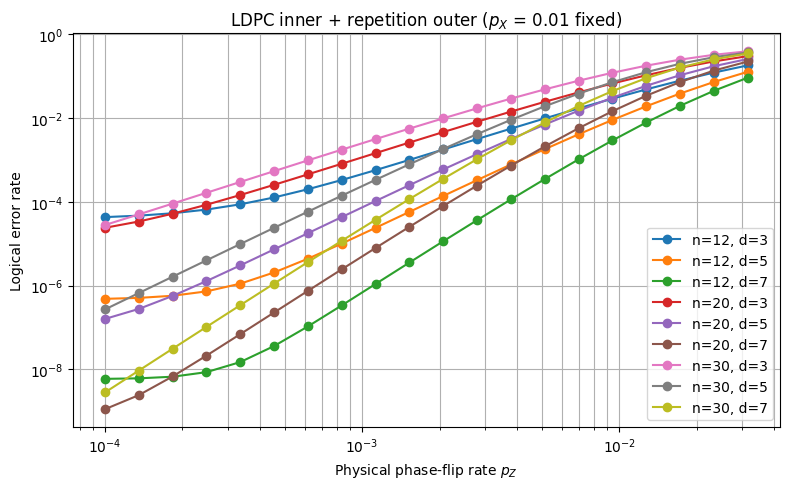

In [136]:

# ---------------------------------------------------------------------------
# Combined: P_L = P(phase) + P(bit) - P(both) ≈ P_L,Z + P_L,X for small rates
# ---------------------------------------------------------------------------
p_X = 0.01   # fixed bit-flip rate
p_Z_vals = np.logspace(-4, -1.5, 20)
shots_ler = 5000   # shots for simulate_ler per (L,H)

inner_sizes = [(3, 4), (4, 5), (5, 6)]   # n = 12, 20, 30
d_outer_vals = [3, 5, 7]

# Precompute per-block logical bit-flip rate at p_X = 0.01 (once per (L,H))
p_L_X_block = {}
for (L, H) in inner_sizes:
    H_mat = build_2d_local_H(L, H)
    p_L_X_block[(L, H)] = max(simulate_ler(H_mat, p_X, shots=shots_ler), 0.5 / shots_ler)
    print(f"L={L}, H={H}: p_L,X,block = {p_L_X_block[(L,H)]:.2e} at p_X={p_X}")

plt.figure(figsize=(8, 5))
for (L, H) in inner_sizes:
    n = L * H
    w = effective_logical_Z_weight(L, H)
    p_L_X_b = p_L_X_block[(L, H)]
    for d_outer in d_outer_vals:
        P_L_X = repetition_logical_error_rate(p_L_X_b, d_outer)  # constant vs p_Z
        P_L_vals = []
        for p_Z in p_Z_vals:
            p_L_Z_b = logical_phase_flip_rate_per_block(p_Z, w)
            P_L_Z = repetition_logical_error_rate(p_L_Z_b, d_outer)
            P_L = P_L_Z + P_L_X   # total logical error (phase or bit)
            P_L_vals.append(P_L)
        plt.loglog(p_Z_vals, P_L_vals, "o-", label=f"n={n}, d={d_outer}")

plt.xlabel("Physical phase-flip rate $p_Z$")
plt.ylabel("Logical error rate")
plt.title(f"LDPC inner + repetition outer ($p_X$ = {p_X} fixed)")
plt.legend()
plt.grid(True, which="both")
plt.tight_layout()
plt.savefig("logical_error_vs_phase_flip_rate.png", dpi=150)
plt.show()

## Magic state factory block

Code            | Data Q  | Anc Q   | Total   | Req p_x (BitFlip)
---------------------------------------------------------------------------
Repetition [3]  | 3       | 2       | 5       | 4.00e-05
Steane [7]      | 7       | 3       | 10      | 3.71e-05
RM [15]         | 15      | 10      | 25      | 2.09e-03
RM [31]         | 31      | 25      | 56      | nan


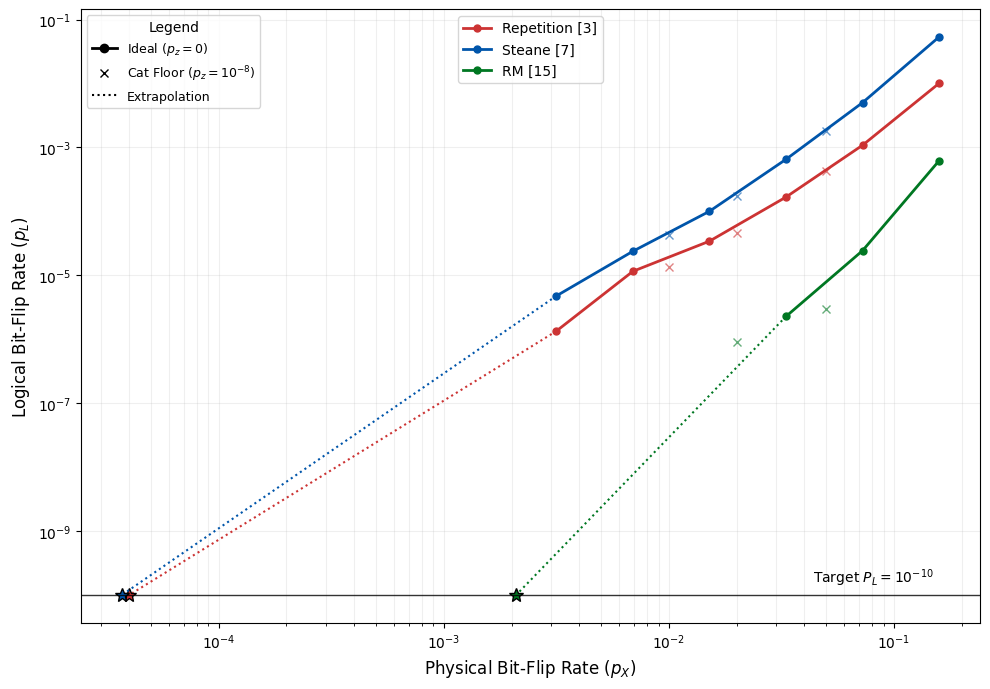

In [138]:
import stim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# --- 1. Stabilizer Generators (Unchanged matrices, interpreted as Z-checks) ---

def get_repetition_3():
    # 3-qubit code. Z-checks: Z0Z1, Z1Z2. Detects X errors.
    return [[0, 1], [1, 2]], [0]

def get_steane_7():
    # Steane code Z-stabilizers
    return [[3, 4, 5, 6], [1, 2, 5, 6], [0, 2, 4, 6]], range(7)

def get_rm_stabilizers(m):
    """
    Generates Stabilizer Matrix for RM codes.
    We will use these as Z-checks to detect X-errors.
    """
    n_full = 2**m
    n = n_full - 1
    
    rows = [np.ones(n, dtype=int)]
    for b in range(m):
        row = [(i >> b) & 1 for i in range(1, n_full)]
        rows.append(np.array(row, dtype=int))
    G = np.array(rows)
    
    stabilizers = []
    rng = np.random.default_rng(42)
    target_checks = n - (m + 1)
    
    attempts = 0
    while len(stabilizers) < target_checks and attempts < 10000:
        attempts += 1
        cand = rng.integers(0, 2, n)
        if not np.any(cand): continue
        
        if np.all(np.dot(G, cand) % 2 == 0):
            current_mat = stabilizers + [cand.tolist()]
            if np.linalg.matrix_rank(np.array(current_mat)) > len(stabilizers):
                stabilizers.append(cand.tolist())
                
    return [np.where(s)[0].tolist() for s in stabilizers], range(n)

# --- 2. Factory Builder (UPDATED: Protects against X-Error) ---

def build_factory_and_count(name, p_dominant, p_minor, p_meas):
    circuit = stim.Circuit()
    
    if "Repetition" in name:
        stabs, log_q = get_repetition_3()
        n = 3
    elif "Steane" in name:
        stabs, log_q = get_steane_7()
        n = 7
    elif "RM [15]" in name:
        stabs, log_q = get_rm_stabilizers(4)
        n = 15
    elif "RM [31]" in name:
        stabs, log_q = get_rm_stabilizers(5)
        n = 31
    else:
        raise ValueError(f"Unknown code: {name}")

    # Count Qubits
    n_data = n
    n_ancilla = len(stabs)
    total_qubits = n_data + n_ancilla

    # --- CIRCUIT GEN (Z-Basis) ---
    # 1. Init Data Qubits in |0> (Z-basis eigenstate)
    circuit.append("R", range(n))
    # Note: NO Hadamard here. We stay in Z-basis to protect against X noise.
    
    # 2. Noise Application
    # p_dominant is now X_ERROR (Bit Flip)
    if p_dominant > 0: circuit.append("X_ERROR", range(n), p_dominant)
    # p_minor is Phase Flip (Z)
    if p_minor > 0: circuit.append("Z_ERROR", range(n), p_minor)
    
    # 3. Syndrome Extraction (Z-Stabilizers)
    # To measure Z parity: CNOT(data -> ancilla), Measure Ancilla
    offset = n
    for i, s in enumerate(stabs):
        anc = offset + i
        circuit.append("R", [anc]) # Init Ancilla in |0>
        
        for q in s:
            circuit.append("CNOT", [q, anc]) # Data controls Ancilla
        
        if p_meas > 0: circuit.append("X_ERROR", [anc], p_meas) # Flip measurement result
        
        circuit.append("M", [anc])
        circuit.append("DETECTOR", [stim.target_rec(-1)], [i, 0, 0])
        
    # 4. Logical Check (Measure Logical Z)
    # Just measure data qubits directly in Z basis
    circuit.append("OBSERVABLE_INCLUDE", [stim.target_z(q) for q in log_q], 0)
    
    return circuit, total_qubits, n_data, n_ancilla

# --- 3. Simulation Logic (Swapped Labels) ---

def calculate_required_phys_error(x_data, y_data, target=1e-10):
    if len(x_data) < 2: return np.nan
    valid = np.array(y_data) > 0
    if np.sum(valid) < 2: return np.nan
    
    log_x = np.log10(np.array(x_data)[valid])
    log_y = np.log10(np.array(y_data)[valid])
    
    slope, intercept, _, _, _ = linregress(log_x, log_y)
    target_log_x = (np.log10(target) - intercept) / slope
    return 10**target_log_x

def run_simulation():
    codes = ["Repetition [3]", "Steane [7]", "RM [15]", "RM [31]"]
    shots = 1_500_000
    
    results = {}
    requirements = []
    
    # Update Header to reflect Bit Flip (p_x)
    print(f"{'Code':<15} | {'Data Q':<7} | {'Anc Q':<7} | {'Total':<7} | {'Req p_x (BitFlip)'}")
    print("-" * 75)
    
    for code in codes:
        # Range selection
        if "RM [31]" in code:
            p_rates = np.logspace(-0.6, -1.5, 6) 
        else:
            p_rates = np.logspace(-0.8, -2.5, 6) 
            
        key_ideal = f"{code}::Ideal"
        key_real = f"{code}::Real"
        results[key_ideal] = {"x": [], "y": []}
        results[key_real] = {"x": [], "y": []}

        # Get Counts
        _, tot, nd, na = build_factory_and_count(code, 0, 0, 0)

        # 1. Sweep Ideal (p_z = 0)
        for p in p_rates:
            # p is now X_ERROR (Dominant)
            # p/10 is Measurement Error
            c, _, _, _ = build_factory_and_count(code, p, 0.0, p/10)
            sampler = c.compile_detector_sampler()
            bd, bo = sampler.sample(shots=shots, separate_observables=True)
            acc = ~np.any(bd, axis=1)
            if np.sum(acc) > 0:
                p_l = np.sum(bo[acc]) / np.sum(acc)
                results[key_ideal]["x"].append(p)
                results[key_ideal]["y"].append(p_l)

        # 2. Sweep Real (With Phase Flip Floor)
        # We assume p_z (phase flip) is the small floor error = 1e-8 (based on your prompt)
        for p in [0.05, 0.02, 0.01]: 
            c, _, _, _ = build_factory_and_count(code, p, 1e-8, p/10)
            sampler = c.compile_detector_sampler()
            bd, bo = sampler.sample(shots=shots, separate_observables=True)
            acc = ~np.any(bd, axis=1)
            if np.sum(acc) > 0:
                p_l = np.sum(bo[acc]) / np.sum(acc)
                results[key_real]["x"].append(p)
                results[key_real]["y"].append(p_l)

        req_p = calculate_required_phys_error(results[key_ideal]["x"], results[key_ideal]["y"])
        requirements.append(req_p)
        print(f"{code:<15} | {nd:<7} | {na:<7} | {tot:<7} | {req_p:.2e}")

    return results, requirements

# --- 4. Plotting (Updated Labels) ---

def plot_final(results, requirements):
    plt.rcParams['font.family'] = 'DejaVu Sans'
    fig, ax = plt.subplots(figsize=(10, 7))
    
    colors = {"Repetition [3]": "#CC3333", "Steane [7]": "#0055AA", 
              "RM [15]": "#007722", "RM [31]": "#663399"}
    
    from matplotlib.lines import Line2D
    # Update legend labels to reflect new physics
    custom_lines = [Line2D([0], [0], color='k', marker='o', lw=2, label='Ideal ($p_z=0$)'),
                    Line2D([0], [0], color='k', marker='x', lw=0, label='Cat Floor ($p_z=10^{-8}$)'),
                    Line2D([0], [0], color='k', linestyle=':', label='Extrapolation')]
    
    for key, data in results.items():
        code = key.split("::")[0]
        scen = key.split("::")[1]
        c = colors[code]
        x, y = np.array(data["x"]), np.array(data["y"])
        mask = y > 0
        x, y = x[mask], y[mask]
        
        if len(x) == 0: continue

        if "Ideal" in scen:
            ax.loglog(x, y, color=c, marker='o', markersize=5, lw=2, label=code)
            req_x = requirements[list(colors.keys()).index(code)]
            if not np.isnan(req_x):
                ax.plot([x[-1], req_x], [y[-1], 1e-10], color=c, linestyle=':', lw=1.5)
                ax.plot(req_x, 1e-10, marker='*', color=c, markersize=10, markeredgecolor='k')
        else:
            ax.loglog(x, y, color=c, marker='x', linestyle='', markersize=6, alpha=0.6)

    ax.axhline(1e-10, color='black', lw=1, alpha=0.8)
    ax.text(0.15, 1.3e-10, r'Target $P_L = 10^{-10}$', va='bottom', ha='right', fontsize=10)

    # Managerial Decision Box (Updated)
    textstr = '\n'.join((
        r'$\bf{Scenario:}$ 120 Cat Qubits',
        r'High Bit-Flip Noise ($p_X=1\%$)',
        r'Solution: $\bf{2\ \times \ RM[31]\ Factories}$'
    ))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # Updated Axis Labels
    ax.set_xlabel(r'Physical Bit-Flip Rate ($p_{X}$)', fontsize=12)
    ax.set_ylabel(r'Logical Bit-Flip Rate ($p_L$)', fontsize=12)
    #ax.set_title('Cat Qubit Factory: Protecting Against Bit Flips', fontsize=14, pad=15)
    ax.grid(True, which="both", alpha=0.2)
    
    leg1 = ax.legend(loc='upper center', frameon=True)
    ax.add_artist(leg1)
    ax.legend(handles=custom_lines, loc='upper left', frameon=True, fontsize=9, title="Legend")
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    res, reqs = run_simulation()
    plot_final(res, reqs)

## Bell Pair Generator

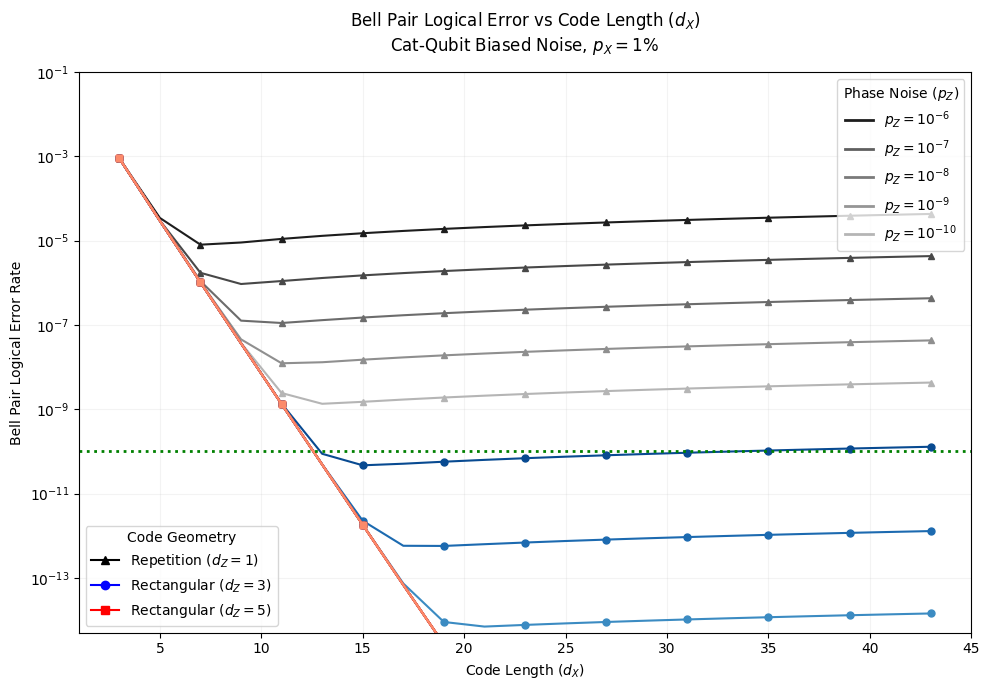

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.special import comb

# -------------------------------------------------
# Bell Pair Generator Model for Cat-Qubit Surface Codes
# -------------------------------------------------

def calc_logical_X(dx, p_x):
    """Logical X failure of one patch"""
    t = dx // 2 + 1
    p_Lx = 0
    for k in range(t, dx + 1):
        p_Lx += comb(dx, k) * (p_x**k) * ((1 - p_x)**(dx - k))
    return p_Lx


def calc_logical_Z(dx, dz, p_z):
    """Logical Z failure (column-wise union bound)"""
    if p_z == 0:
        return 0

    t = dz // 2 + 1
    p_col = 0
    for k in range(t, dz + 1):
        p_col += comb(dz, k) * (p_z**k) * ((1 - p_z)**(dz - k))

    return 1 - (1 - p_col)**dx


def calc_parity_failure(dx, p_x):
    """
    Failure of Z_L1 ⊗ Z_L2 parity measurement during lattice surgery.
    Modeled as a majority vote over dx rounds.
    """
    t = dx // 2 + 1
    p_fail = 0
    for k in range(t, dx + 1):
        p_fail += comb(dx, k) * (p_x**k) * ((1 - p_x)**(dx - k))
    return p_fail


def calc_bell_error(dx, dz, p_x, p_z):
    """
    Total Bell-pair logical error probability
    """
    p_Lx = calc_logical_X(dx, p_x)
    p_Lz = calc_logical_Z(dx, dz, p_z)
    p_parity = calc_parity_failure(dx, p_x)

    # Bell pair fails if:
    # - either patch has logical X
    # - parity measurement fails
    p_bell = 1 - (1 - p_Lx)**2 * (1 - p_parity)

    # Phase errors contribute independently (small correction)
    return p_bell + p_Lz


# -------------------------------------------------
# Plot (style preserved from original code)
# -------------------------------------------------

def plot_bell_generator():
    p_x = 0.01
    p_z_levels = [1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
    lengths = range(3, 45, 2)

    configs = {
        1: {'name': 'Repetition ($d_Z=1$)', 'cmap': plt.cm.Greys, 'marker': '^'},
        3: {'name': 'Rectangular ($d_Z=3$)', 'cmap': plt.cm.Blues, 'marker': 'o'},
        5: {'name': 'Rectangular ($d_Z=5$)', 'cmap': plt.cm.Reds,  'marker': 's'}
    }

    fig, ax = plt.subplots(figsize=(10, 7))

    for dz, cfg in configs.items():
        colors = cfg['cmap'](np.linspace(0.9, 0.4, len(p_z_levels)))

        for i, p_z in enumerate(p_z_levels):
            y_vals = [
                calc_bell_error(dx, dz, p_x, p_z)
                for dx in lengths
            ]

            ax.semilogy(
                lengths, y_vals,
                color=colors[i],
                marker=cfg['marker'],
                linestyle='-',
                linewidth=1.5,
                markersize=5,
                markevery=2,
                label='_nolegend_'
            )

    # Target line
    ax.axhline(1e-10, color='green', linestyle=':', linewidth=2,
               label='Target ($10^{-10}$)')

    # Legends
    legend_geom = [
        Line2D([0], [0], marker='^', color='black', label='Repetition ($d_Z=1$)'),
        Line2D([0], [0], marker='o', color='blue',  label='Rectangular ($d_Z=3$)'),
        Line2D([0], [0], marker='s', color='red',   label='Rectangular ($d_Z=5$)')
    ]

    legend_noise = [
        Line2D([0], [0], color=plt.cm.Greys(0.9), lw=2, label='$p_Z=10^{-6}$'),
        Line2D([0], [0], color=plt.cm.Greys(0.7), lw=2, label='$p_Z=10^{-7}$'),
        Line2D([0], [0], color=plt.cm.Greys(0.6), lw=2, label='$p_Z=10^{-8}$'),
        Line2D([0], [0], color=plt.cm.Greys(0.5), lw=2, label='$p_Z=10^{-9}$'),
        Line2D([0], [0], color=plt.cm.Greys(0.4), lw=2, label='$p_Z=10^{-10}$')
    ]

    leg1 = ax.legend(handles=legend_geom, title="Code Geometry",
                     loc="lower left", frameon=True)
    ax.add_artist(leg1)

    ax.legend(handles=legend_noise, title="Phase Noise ($p_Z$)",
              loc="upper right", frameon=True)

    ax.set_title(
        "Bell Pair Logical Error vs Code Length ($d_X$)\n"
        "Cat-Qubit Biased Noise, $p_X=1\\%$",
        pad=15
    )

    ax.set_xlabel("Code Length ($d_X$)")
    ax.set_ylabel("Bell Pair Logical Error Rate")
    ax.set_ylim(0.5e-14, 1e-1)
    ax.grid(True, which='both', alpha=0.15)

    plt.tight_layout()
    plt.show()


plot_bell_generator()

# Extra